<a href="https://colab.research.google.com/github/ptnv-s/Knee-Abnormality-and-Common-Disorders-Detection/blob/main/MRNet_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Musculoskeletal Diagnosis, Abnormality and Common Disorders detection using Knee Magnetic Resonance Imaging

---

Magnetic resonance (MR) imaging of the knee is the standard of care imaging modality to evaluate knee disorders, and more musculoskeletal MR examinations are performed on the knee than on any other region of the body.

---

We will be implementing deep learning baselines for detecting general abnormalities and specific diagnoses (anterior cruciate ligament [ACL] tears and meniscal tears) on knee MRI exams.

---

The most common indications for the knee MRI examinations in this study included acute and chronic pain, follow-up or preoperative evaluation, injury/trauma.

---
We have used the [MRNet dataset](https://stanfordmlgroup.github.io/competitions/mrnet/)  which consists of 1,370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams, with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears. The labels were obtained through manual extraction from clinical reports.

---

Examinations were performed with GE scanners (GE Discovery, GE Healthcare, Waukesha, WI) with standard knee MRI coil and a routine non-contrast knee MRI protocol that included the following sequences: coronal T1 weighted, coronal T2 with fat saturation, sagittal proton density (PD) weighted, sagittal T2 with fat saturation, and axial PD weighted with fat saturation. A total of 775 (56.6%) examinations used a 3.0-T magnetic field the remaining used a 1.5-T magnetic field as reported [here](https://stanfordmlgroup.github.io/projects/mrnet/) .

For more details refer to the paper related to this study [here](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699).

---

Given a MRI scan our deep learning model will be predicting 3 outcomes for knee MRI exams (anterior cruciate ligament [ACL] tears, meniscal tears, and general abnormalities).

#### Importing Basic Libraries

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Medical/MRNet-v1.0

/content/drive/MyDrive/Medical/MRNet-v1.0


In [4]:
pwd

'/content/drive/MyDrive/Medical/MRNet-v1.0'

### Exploring Dataset and the File/Folder Structure
This data comes as split dataset (training & validation in separate directories). 
Each data categories such as training & validation has sub-directories (pls see below).

In [5]:
!ls

train		    train-acl.csv	valid		    valid-acl.csv
train-abnormal.csv  train-meniscus.csv	valid-abnormal.csv  valid-meniscus.csv


#### Lets Explore the Training Set of the Dataset.
We will try to find out the total number of the training examples and the examples in each category of conclusion of the knee MRI examinations made by the clinical expert.


In [6]:
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainAb_labels=[]
    for row in csv_reader:
           trainAb_labels.append(int(row[1]))
trainAb_labels= np.array(trainAb_labels)

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainACL_labels=[]
    for row in csv_reader:
           trainACL_labels.append(int(row[1]))
trainACL_labels= np.array(trainACL_labels)



with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainMen_labels=[]
    for row in csv_reader:
           trainMen_labels.append(int(row[1]))
trainMen_labels= np.array(trainMen_labels)

print("Total No of Observations in the Training Set : "+str(len(trainAb_labels)))
print("No of Abnormal Investigation Cases : "+str(len(trainAb_labels)-np.count_nonzero(trainAb_labels)))
print("No of ACL tears Investigation Cases : "+str(len(trainACL_labels)-np.count_nonzero(trainACL_labels)))
print("No of Meniscal tears Investigation Cases : "+str(len(trainMen_labels)-np.count_nonzero(trainMen_labels)))

Total No of Observations in the Training Set : 1130
No of Abnormal Investigation Cases : 217
No of ACL tears Investigation Cases : 922
No of Meniscal tears Investigation Cases : 733


#### We now try to find the same above investigation for validation set.

In [7]:
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testAb_labels=[]
    for row in csv_reader:
           testAb_labels.append(int(row[1]))

testAb_labels= np.array(testAb_labels)

with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testACL_labels=[]
    for row in csv_reader:
           testACL_labels.append(int(row[1]))

testACL_labels= np.array(testACL_labels)


with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testMen_labels=[]
    for row in csv_reader:
           testMen_labels.append(int(row[1]))

testMen_labels= np.array(testMen_labels)


print("Total No of Observations in the Training Set : "+str(len(testAb_labels)))
print("No of Abnormal Investigation Cases : "+str(len(testAb_labels)-np.count_nonzero(testAb_labels)))
print("No of ACL tears Investigation Cases : "+str(len(testACL_labels)-np.count_nonzero(testACL_labels)))
print("No of Meniscal tears Investigation Cases : "+str(len(testMen_labels)-np.count_nonzero(testMen_labels)))

Total No of Observations in the Training Set : 120
No of Abnormal Investigation Cases : 25
No of ACL tears Investigation Cases : 66
No of Meniscal tears Investigation Cases : 68


In [8]:
train_dir = 'train'
valid_dir = 'valid'

##### Now let us check for whether there is any disparity in the dataset.

As we know this dataset has 3 views of Knee since datset has MRI scans namely - 

*   Axial
*   Coronal
*   Sagittal


 
 

In [9]:
planes = ['axial', 'coronal', 'sagittal']
datasets = {'train': train_dir, 'valid': valid_dir}

for dataset, path in datasets.items():
    print(f'\nNumber of exams in {dataset} set:')
    for plane in planes:
        print(plane, len(glob(f'{path}/{plane}/*.npy')))


Number of exams in train set:
axial 1130
coronal 1130
sagittal 1130

Number of exams in valid set:
axial 120
coronal 120
sagittal 120


##### Lets us check the dimensions of each file/ scan of a particular view of a patient's Knee.

In [10]:
train_axial_exams = glob(f'{train_dir}/axial/*.npy')[:5]

for exam in train_axial_exams:
    series = np.load(exam)
    print(series.shape)

(32, 256, 256)
(32, 256, 256)
(39, 256, 256)
(36, 256, 256)
(39, 256, 256)


Helper Functon for plotting

In [11]:
def plot_first_ten(path):
    series = np.load(path)[:10]

    fig = plt.figure(figsize=(20, 6))
    
    for i, image in enumerate(series):
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        plt.imshow(image, cmap='gray')
        plt.axis('off');

Plotting results-

(Commented Since Dataset requires special access - apply [here](https://stanfordmlgroup.github.io/competitions/mrnet/))

In [12]:
#plot_first_ten(train_axial_exams[0])

Helper Function for Plotting the distribution 

In [13]:
def get_num_images_per_exam(exams):
    num_images_per_exam = []
    
    for exam in exams:
        series = np.load(exam)
        num_images_per_exam.append(series.shape[0])
        
    return np.asarray(num_images_per_exam)

def plot_num_images_per_exam(dataset_path):
    f, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
    
    for i, plane in enumerate(planes):
        paths = glob(f'{dataset_path}/{plane}/*.npy')
        
        num_images = get_num_images_per_exam(paths)
        print(f'{plane} - min: {num_images.min()}, max: {num_images.max()}')

        sns.distplot(num_images, ax=axes[i])
        axes[i].set_title(f'{plane} plane')

### Visualise distrubutions of number of images in a series

Let's have a look at the distributions for **train**  and **valid** datasets.

axial - min: 19, max: 61


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


coronal - min: 17, max: 58


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sagittal - min: 17, max: 51


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


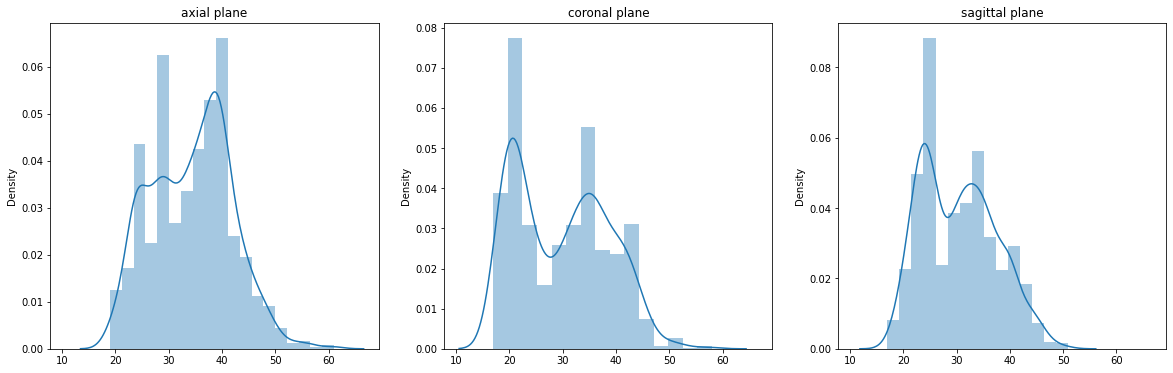

In [14]:
plot_num_images_per_exam(train_dir)

axial - min: 20, max: 52


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


coronal - min: 17, max: 48


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


sagittal - min: 21, max: 45


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


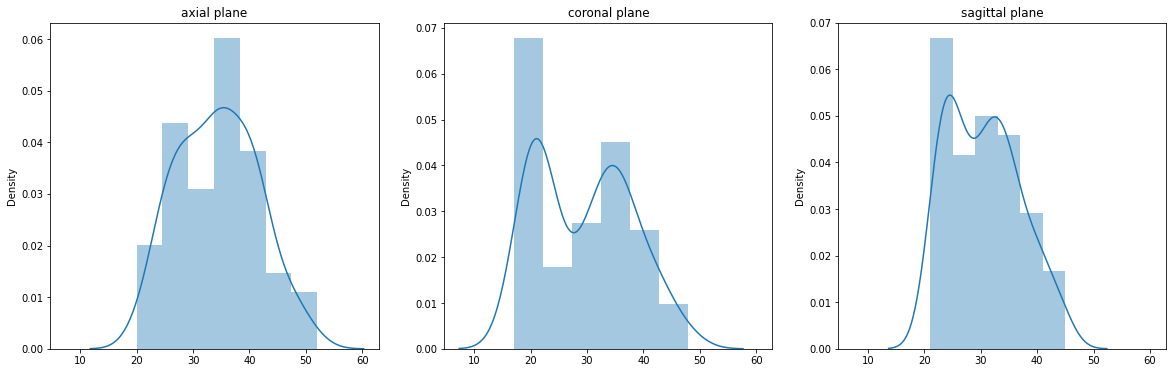

In [15]:
plot_num_images_per_exam(valid_dir)

##### Helper Function for Visualization of Category of Distribution

In [16]:
def label_race (row):
  if row['meniscus'] == 0 and row['acl'] == 0 and row['abnormal'] == 0:
    return 'Nothing Detected'
  if row['meniscus'] == 0 and row['acl'] == 0 and row['abnormal'] == 1:
    return 'Meniscus Only'
  if row['meniscus'] == 1 and row['acl'] == 0 and row['abnormal'] == 1:
    return 'Meniscus + Abnormal'
  if row['meniscus'] == 0 and row['acl'] == 1 and row['abnormal'] == 1:
    return 'Meniscus + Acl'
  if row['meniscus'] == 1 and row['acl'] == 1 and row['abnormal'] == 1:
    return 'Meniscus + Acl + Abnormal'
  return None

#### Analyzing the positive negative cases in dataset and then checking for MIssing Values

In [17]:
train_abnormal_df = pd.read_csv('train-abnormal.csv',header=None,names=['case', 'abnormal'],dtype={'case': str, 'abnormal': np.int64})
print(train_abnormal_df.groupby('abnormal').count())


          case
abnormal      
0          217
1          913


In [18]:
train_abnormal_df.head()

,case,abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [19]:
print('\nMissing values: ', train_abnormal_df.isnull().values.any())


Missing values:  False


In [20]:
train_acl_df = pd.read_csv('train-acl.csv',header=None,names=['case', 'acl'],dtype={'case': str, 'acl': np.int64})
train_acl_df.head()

,case,acl
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [21]:
print(train_acl_df.groupby('acl').count())

     case
acl      
0     922
1     208


In [22]:
print('\nMissing values: ', train_acl_df.isnull().values.any())


Missing values:  False


In [23]:
train_meniscus_df = pd.read_csv('train-meniscus.csv',header=None,names=['case', 'meniscus'],dtype={'case': str, 'meniscus': np.int64})
print(train_meniscus_df.groupby('meniscus').count())


          case
meniscus      
0          733
1          397


In [24]:
train_meniscus_df.head()

,case,meniscus
0,0000,0
1,0001,1
2,0002,0
3,0003,1
4,0004,0


In [25]:
print('\nMissing values: ', train_meniscus_df.isnull().values.any())


Missing values:  False


#### Lets Merge Dataset to see Distribution of How Many Belong to more than 1 category

In [26]:
train_df = pd.merge(train_abnormal_df, train_acl_df, on='case').merge(train_meniscus_df, on='case')
train_df.head()

,case,abnormal,acl,meniscus
0,0000,1,0,0
1,0001,1,1,1
2,0002,1,0,0
3,0003,1,0,1
4,0004,1,0,0


In [27]:
train_df['diagnostic_label'] = train_df.apply (lambda row: label_race(row), axis=1)

#### Preprocessing and Merging the Validation Dataset

In [28]:
valid_abnormal_df = pd.read_csv('valid-abnormal.csv',header=None,names=['case', 'abnormal'],dtype={'case': str, 'abnormal': np.int64})
valid_acl_df = pd.read_csv('valid-acl.csv',header=None,names=['case', 'acl'],dtype={'case': str, 'acl': np.int64})
valid_meniscus_df = pd.read_csv('valid-meniscus.csv',header=None,names=['case', 'meniscus'],dtype={'case': str, 'meniscus': np.int64})
valid_df = pd.merge(valid_abnormal_df, valid_acl_df, on='case').merge(valid_meniscus_df, on='case')
valid_df.head()

,case,abnormal,acl,meniscus
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0


In [29]:
valid_df['diagnostic_label'] = valid_df.apply (lambda row: label_race(row), axis=1)

In [30]:
valid_df.tail()

,case,abnormal,acl,meniscus,diagnostic_label
115,1245,1,1,1,Meniscus + Acl + Abnormal
116,1246,1,1,1,Meniscus + Acl + Abnormal
117,1247,1,0,1,Meniscus + Abnormal
118,1248,1,1,1,Meniscus + Acl + Abnormal
119,1249,1,0,1,Meniscus + Abnormal


#### Plotting Visualization for Distribution of the Dataset

In [31]:
pd.options.display.float_format = '{:,.1f}'.format
train_co_occurency_df = train_df.groupby(['diagnostic_label']).count().reset_index()
train_co_occurency_df['%_freq'] = (train_co_occurency_df.case / train_co_occurency_df.case.sum()) * 100
train_co_occurency_df.head()

,diagnostic_label,case,abnormal,acl,meniscus,%_freq
0,Meniscus + Abnormal,272,272,272,272,24.1
1,Meniscus + Acl,83,83,83,83,7.3
2,Meniscus + Acl + Abnormal,125,125,125,125,11.1
3,Meniscus Only,433,433,433,433,38.3
4,Nothing Detected,217,217,217,217,19.2


In [32]:
train_co_occurency_df = train_co_occurency_df.drop(['abnormal', 'acl', 'meniscus'], axis = 1)

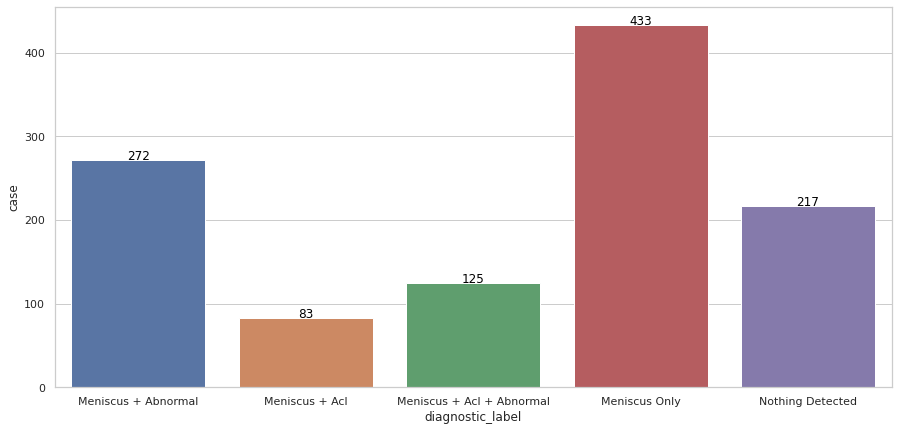

In [33]:
plt.figure(figsize=(15, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="diagnostic_label", y="case", data=train_co_occurency_df)
for index, row in train_co_occurency_df.iterrows():
    ax.text(row.name, row.case, round(row.case, 2),
            color='black', ha='center')

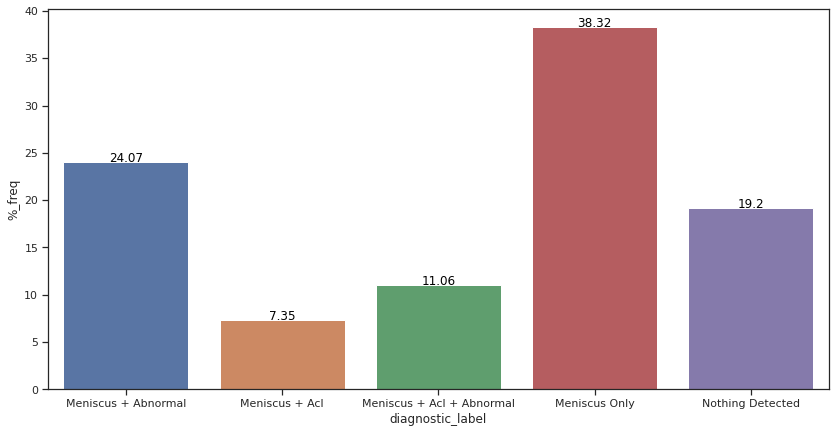

In [34]:

plt.figure(figsize=(14, 7))
sns.set_theme(style="ticks")
ax = sns.barplot(x="diagnostic_label", y="%_freq", data=train_co_occurency_df)
for index, row in train_co_occurency_df.iterrows():
    ax.text(row.name, row["%_freq"], round(row["%_freq"], 2),
            color='black', ha='center')

In [35]:
pd.options.display.float_format = '{:,.1f}'.format
valid_co_occurency_df = valid_df.groupby(['diagnostic_label']).count().reset_index()
valid_co_occurency_df['%_freq'] = (valid_co_occurency_df.case / valid_co_occurency_df.case.sum()) * 100
valid_co_occurency_df.head()

,diagnostic_label,case,abnormal,acl,meniscus,%_freq
0,Meniscus + Abnormal,21,21,21,21,17.5
1,Meniscus + Acl,23,23,23,23,19.2
2,Meniscus + Acl + Abnormal,31,31,31,31,25.8
3,Meniscus Only,20,20,20,20,16.7
4,Nothing Detected,25,25,25,25,20.8


In [36]:
valid_co_occurency_df = valid_co_occurency_df.drop(['abnormal', 'acl', 'meniscus'], axis = 1)

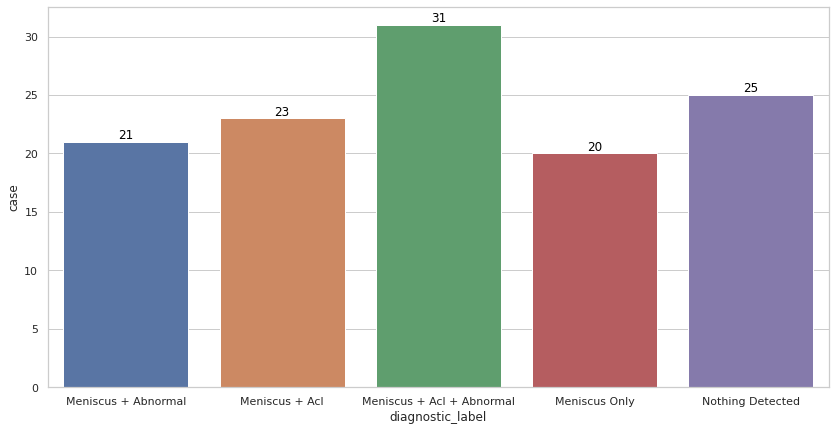

In [37]:

plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="diagnostic_label", y="case", data=valid_co_occurency_df)
for index, row in valid_co_occurency_df.iterrows():
    ax.text(row.name, row.case, round(row.case, 2),
            color='black', ha='center',va= 'bottom')

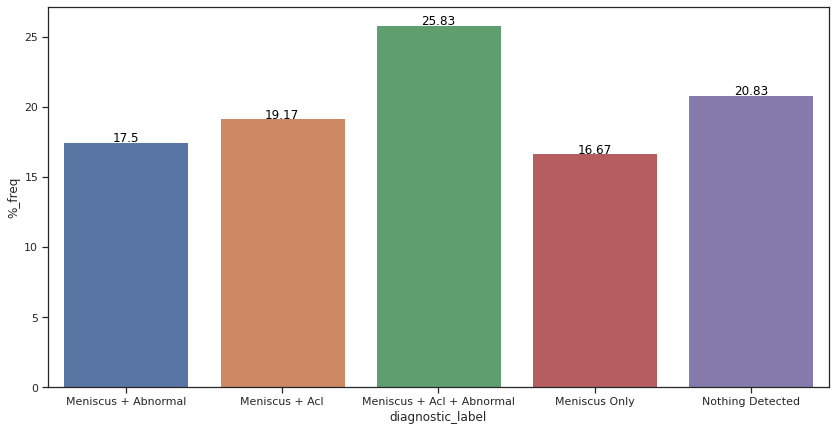

In [38]:

plt.figure(figsize=(14, 7))
sns.set_theme(style="ticks")
ax = sns.barplot(x="diagnostic_label", y="%_freq", data=valid_co_occurency_df)
for index, row in valid_co_occurency_df.iterrows():
    ax.text(row.name, row["%_freq"], round(row["%_freq"], 2),
            color='black', ha='center')